In [1]:
%matplotlib inline
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt

In [2]:
WEIGHT_DIR = "./mask-rcnn-coco"
INPUT_DIR = "./input"
OUTPUT_DIR = "./output"

In [3]:
# load the COCO class labels our Mask R-CNN was trained on
labelsPath = os.path.join(WEIGHT_DIR, "object_detection_classes_coco.txt")
LABELS = open(labelsPath).read().strip().split("\n")

In [4]:
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

In [5]:
# derive the paths to the Mask R-CNN weights and model configuration
weightsPath = os.path.join(WEIGHT_DIR, "frozen_inference_graph.pb")
configPath = os.path.join(WEIGHT_DIR, "mask_rcnn_inception_v2_coco_2018_01_28.pbtxt")

In [6]:
# load our Mask R-CNN trained on the COCO dataset (90 classes)
net = cv2.dnn.readNetFromTensorflow(weightsPath, configPath)

In [7]:
# load our input image and grab its spatial dimensions
image = cv2.imread(os.path.join(INPUT_DIR, "input.jpg"), 1)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

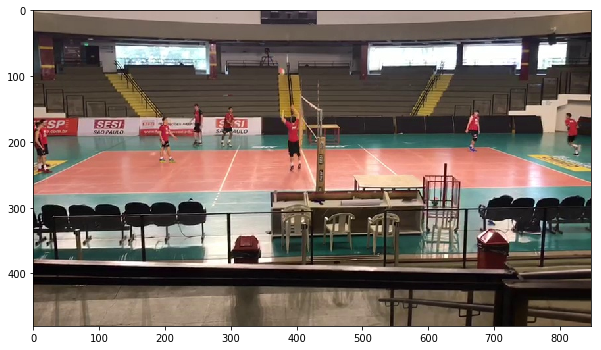

In [8]:
plt.figure(figsize=(10, 15))
plt.imshow(rgb)

In [9]:
H, W, _ = image.shape
image.shape

(480, 848, 3)

In [10]:
blob = cv2.dnn.blobFromImage(image, swapRB=True, crop=False)
net.setInput(blob)

In [11]:
boxes, masks = net.forward(["detection_out_final", "detection_masks"])

In [12]:
print("[INFO] boxes shape: {}".format(boxes.shape))
print("[INFO] masks shape: {}".format(masks.shape))

[INFO] boxes shape: (1, 1, 15, 7)
[INFO] masks shape: (100, 90, 15, 15)


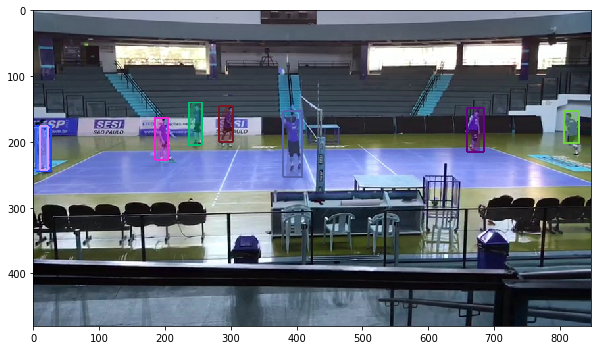

In [13]:
clone = image.copy()
for i in range(0, boxes.shape[2]):

    classID = int(boxes[0, 0, i, 1])
    if classID == 0:

        box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H])
        startX, startY, endX, endY = box.astype("int")
        boxW = endX - startX
        boxH = endY - startY
        
        mask = masks[i, classID]
        mask = cv2.resize(mask, (boxW, boxH), interpolation=cv2.INTER_NEAREST)
        mask = (mask > 0.3)
        
        roi = clone[startY:endY, startX:endX]
        roi = roi[mask]
        
        color = random.choice(COLORS)
        blended = ((0.4 * color) + (0.6 * roi))
        clone[startY:endY, startX:endX][mask] = blended
        
        color = [int(c) for c in color]
        cv2.rectangle(clone, (startX, startY), (endX, endY), color, 2)

plt.figure(figsize=(10, 15))
plt.imshow(clone)

In [14]:
# initialize the video stream and pointer to output video file
vs = cv2.VideoCapture(os.path.join(INPUT_DIR, "input.mp4"))
writer = None

In [16]:
while(True):
    # Capture frame-by-frame
    ret, frame = vs.read()
    
    if not ret:
        break

    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    blob = cv2.dnn.blobFromImage(frame, swapRB=True, crop=False)
    net.setInput(blob)
    boxes, masks = net.forward(["detection_out_final", "detection_masks"])
    
    for i in range(0, boxes.shape[2]):
        
        classID = int(boxes[0, 0, i, 1])
        if classID == 0:
        
            box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H])
            startX, startY, endX, endY = box.astype("int")
            boxW = endX - startX
            boxH = endY - startY
        
            mask = masks[i, classID]
            mask = cv2.resize(mask, (boxW, boxH), interpolation=cv2.INTER_NEAREST)
            mask = (mask > 0.3)
        
            roi = frame[startY:endY, startX:endX][mask]
        
            color = COLORS[classID]
            blended = ((0.4 * color) + (0.6 * roi)).astype("uint8")
        
            frame[startY:endY, startX:endX][mask] = blended
        
            color = [int(c) for c in color]
            cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
            
    # check if the video writer is None
    if writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"XVID")
        writer = cv2.VideoWriter(os.path.join(OUTPUT_DIR, "output.avi"), fourcc, 30, (frame.shape[1], frame.shape[0]), True)

    # write the output frame to disk
    writer.write(frame)

In [17]:
writer.release()
vs.release()